We hypothesise that there will be two significant peaks in the greyscale intesity of the CT scans, due to edge effects: these will be at the boundary between air and the cementum, and at the cementum-dentine boundary.

To check this we will find 4 random images from 4 teeth, straighten them and plot the greyscale intensity along each row. Hopefully we will see these two peaks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Choose images

"""
import os
import numpy as np

rng = np.random.default_rng(seed=0)

# Pick four numbers for each tooth
n_slices = 4
n_teeth = 3
indices = [
    *rng.integers(0, 108, n_slices),
    *rng.integers(108, 216, n_slices),
    *rng.integers(216, 316, n_slices),
    # *rng.integers(316, 515, 4), Not using this one for now, since the edge detection doesn't work for it
]
assert len(indices) == n_slices * n_teeth

# Find the corresponding filepaths
img_paths = [f"data/original cut/{i:04d}.tif" for i in indices]
mask_paths = [f"data/masks cut/{i:04d}.tif" for i in indices]

for path in img_paths:
    assert os.path.exists(path), path

for path in mask_paths:
    assert os.path.exists(path), path

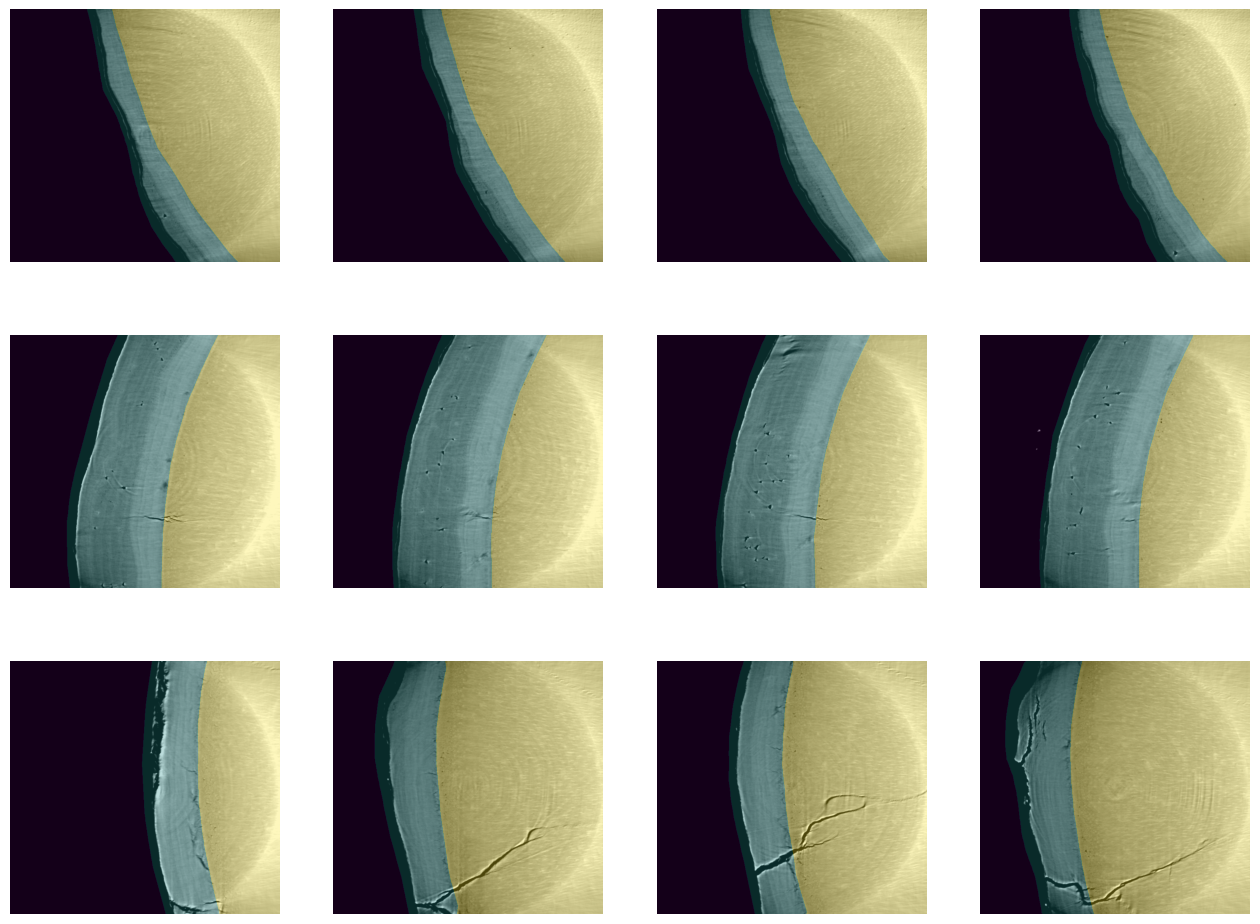

In [3]:
"""
Display them

"""
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for axis, img, mask in zip(axes.flat, img_paths, mask_paths):
    axis.imshow(plt.imread(img), cmap="gray")
    axis.imshow(plt.imread(mask), alpha=0.3)

    axis.set_axis_off()

imgdir = "img/check_greyscale_function"
if not os.path.isdir(imgdir):
    os.mkdir(imgdir)

fig.savefig(f"{imgdir}/img_masks.png", bbox_inches="tight")

  0%|          | 0/12 [00:00<?, ?it/s]/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 98 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 56 zero rows from bottom
  warnings.warn(
  8%|▊         | 1/12 [00:02<00:22,  2.04s/it]/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 102 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 59 zero rows from bottom
  warnings.warn(
 17%|█▋        | 2/12 [00:04<00:20,  2.01s/it]/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 60 zero rows from bottom
  warnings.warn(
 25%|██▌       | 3/12 [00:05<00:17,  1.98s/it]/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 99 saturated columns from right
  warning

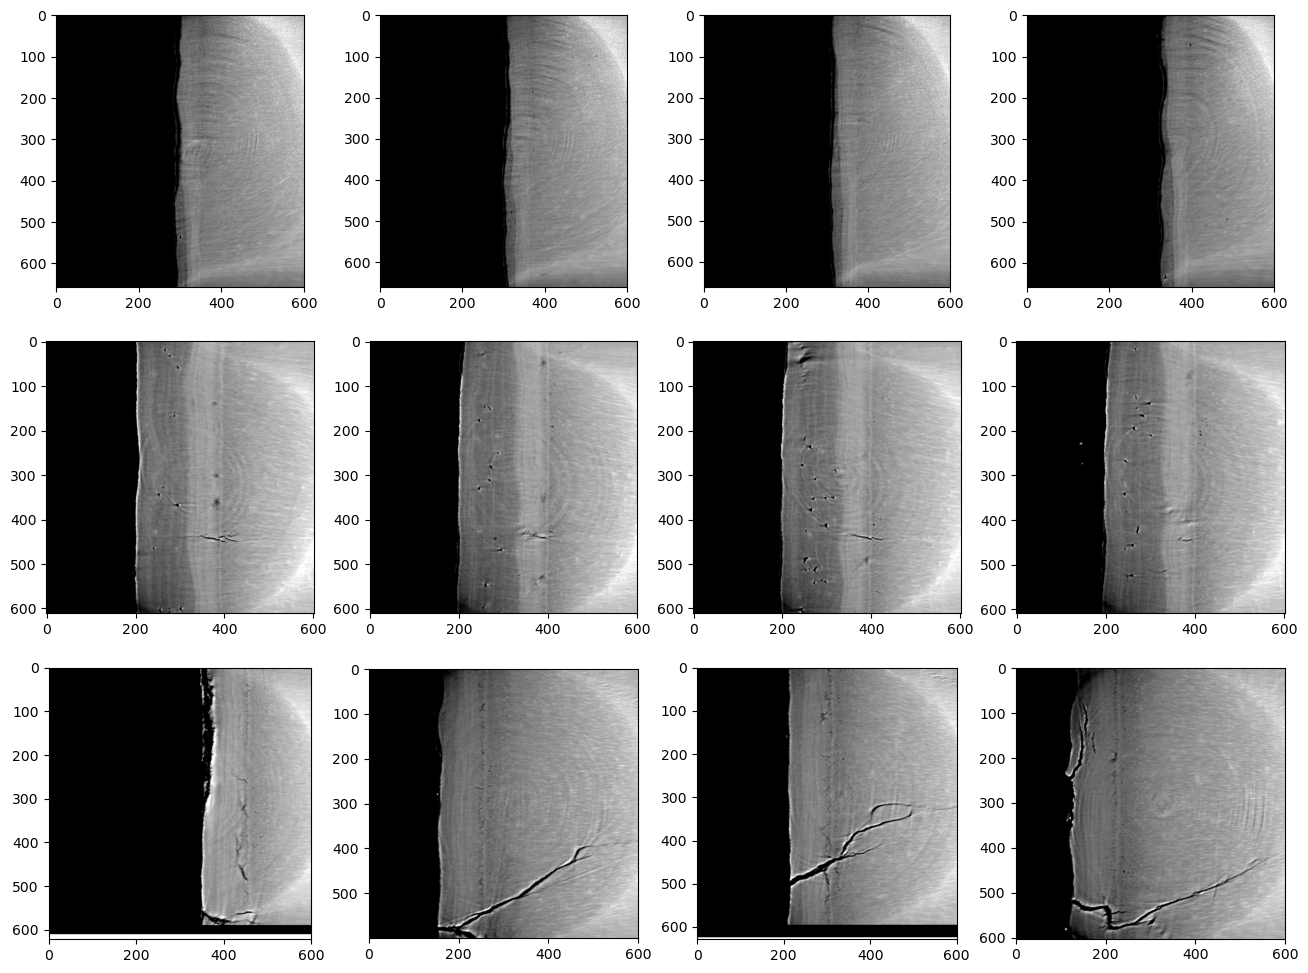

In [4]:
"""
Straighten these images according the the masks

"""
from tqdm import tqdm

from cementum import straighten

n_y = 20
n_left, n_x, n_right = 5, 5, 5

fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

straight_images, straight_masks = [], []

for axis, img_path, mask_path in tqdm(
    zip(axes.flat, img_paths, mask_paths), total=len(img_paths)
):
    # Define two grids of points that will we use to perform our straightening
    mask = plt.imread(mask_path)
    curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
    straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))

    # Straighten the image
    img = plt.imread(img_path)
    straight_image = straighten.apply_transformation(img, curve_pts, straight_pts)

    # Straighten the mask
    straight_mask = straighten.apply_transformation(mask, curve_pts, straight_pts)

    # Remove the white columns from the image and the corresponding columns from the mask
    straight_image, straight_mask = straighten.remove_white_cols(
        straight_image, straight_mask
    )

    # Remove padding
    straight_image = straighten.remove_padding(straight_image)
    straight_mask = straighten.remove_padding(straight_mask)

    straight_images.append(straight_image)
    straight_masks.append(straight_mask)

    # Display it
    axis.imshow(straight_images[-1], cmap="gray")


fig.savefig(f"{imgdir}/straightened.png", bbox_inches="tight")

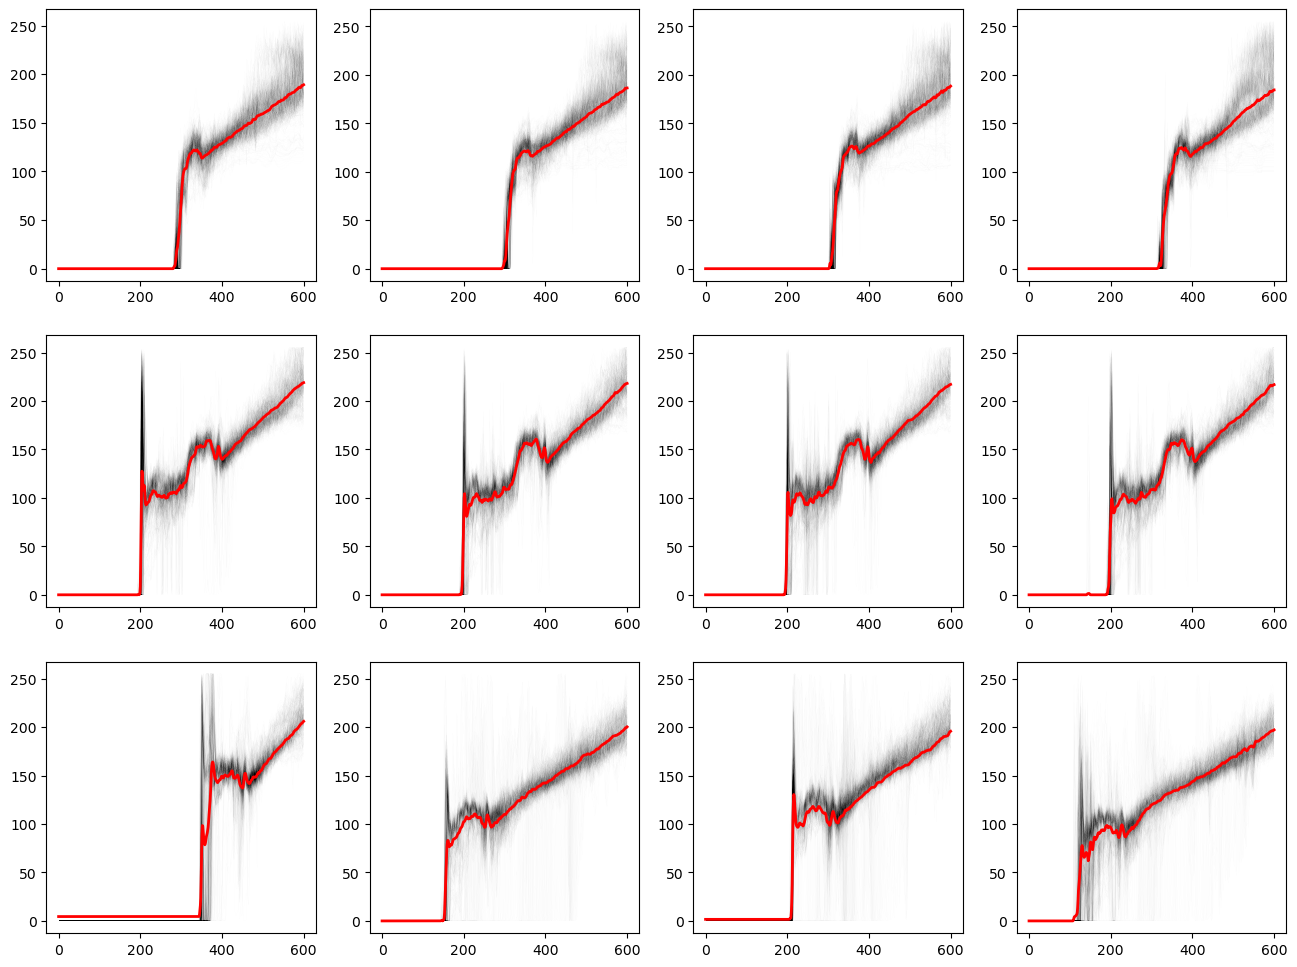

In [5]:
"""
Plot the greyscale intensity across each row for all of these images

"""
fig, axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for axis, img in zip(axes.flat, straight_images):
    for row in img:
        axis.plot(row, alpha=0.05, linewidth=0.05, color="k")
    axis.plot(np.mean(img, axis=0), color="r", linewidth=2)

fig.savefig(f"{imgdir}/intensities.png", bbox_inches="tight")

In some of the samples, two peaks at the boundaries are very clear - in the first it can't really be seen at all.

As a first attempt, let's try fitting a straight line to the first 100 pixels of the image...

100%|██████████| 12/12 [00:00<00:00, 785.63it/s]


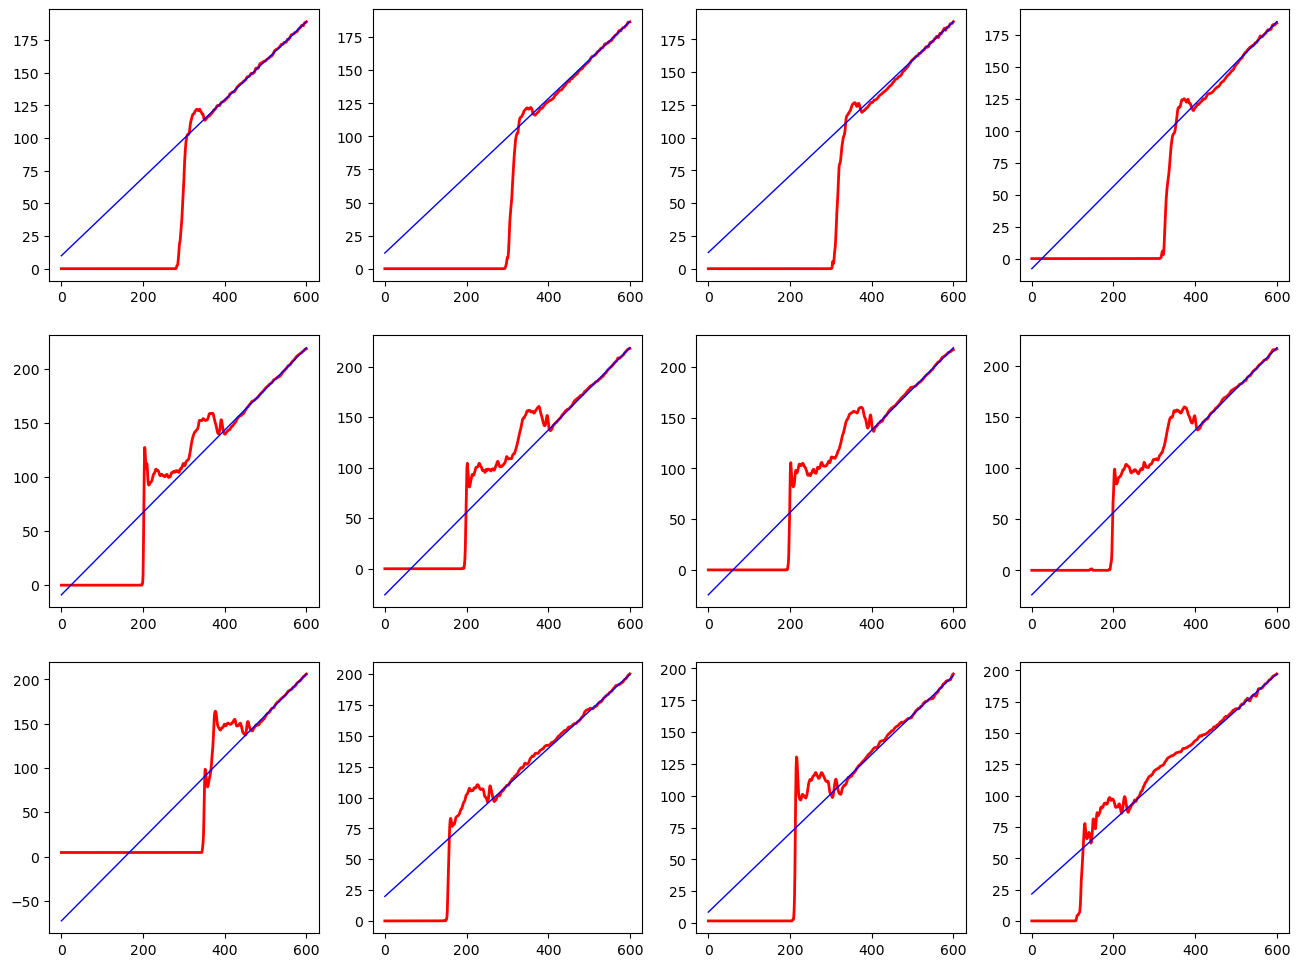

In [6]:
"""
Try to fit the intensity profiles - first fit just to the rightmost 100 pixels

"""
from cementum import fit_cementum

n_pixels = 100

fit_fig, fit_axes = plt.subplots(n_teeth, n_slices, figsize=(4 * n_slices, 4 * n_teeth))

for image, fit_axis in tqdm(
    zip(straight_images, fit_axes.flat), total=len(straight_images)
):
    intensity_profile = np.mean(image, axis=0)
    params, _ = fit_cementum.fit_line(n_pixels, intensity_profile)

    x = np.arange(image.shape[1])
    fit_axis.plot(x, intensity_profile, color="r", linewidth=2)
    fit_axis.plot(x, fit_cementum._line(x, *params), color="b", linewidth=1)